In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [6]:
dataset = 'cifar10'
dims = (32,32,3)

In [7]:
from tensorflow.keras.datasets import cifar10

In [8]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = cifar10.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

40000 10000 10000


### define networks

In [9]:
dims = (32,32,3)
n_components = 64

In [10]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

### Create model and train

In [11]:
batch_size = 5000

In [12]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [13]:
from tfumap.parametric_tsne import compute_joint_probabilities, tsne_loss

In [14]:
save_loc = DATA_DIR/ 'parametric_tsne'/ dataset / 'P.npy'
if save_loc.exists():
    P = np.load(save_loc)
else:
    P = compute_joint_probabilities(X_train_flat, batch_size=batch_size, perplexity=30, verbose=2)
    ensure_dir(save_loc)
    np.save(save_loc, P)

In [15]:
# Joint probabilities of data
Y_train_tsne = P.reshape(X_train.shape[0], -1)

In [16]:
opt = tf.keras.optimizers.Adam(lr=0.01)

In [17]:
encoder.compile(loss=tsne_loss(d=n_components, batch_size=batch_size), optimizer=opt)

In [18]:
X_train = np.reshape(X_train, ([len(X_train)]+ list(dims)))
X_test = np.reshape(X_test, ([len(X_test)]+ list(dims)))

In [19]:
# because shuffle == False, the same batches are used each time...
history = encoder.fit(X_train, Y_train_tsne, batch_size=batch_size, shuffle=False, nb_epoch=1000)

W0720 11:27:23.952897 140341886531392 training.py:792] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 40000 samples
Epoch 1/1000
40000/40000 [==============================] - 20s 493us/sample - loss: 5.0721
Epoch 2/1000
40000/40000 [==============================] - 1s 32us/sample - loss: 2.4812
Epoch 3/1000
40000/40000 [==============================] - 2s 58us/sample - loss: 1.9405
Epoch 4/1000
40000/40000 [==============================] - 3s 63us/sample - loss: 1.6573
Epoch 5/1000
40000/40000 [==============================] - 2s 53us/sample - loss: 1.4786
Epoch 6/1000
40000/40000 [==============================] - 3s 77us/sample - loss: 1.3569
Epoch 7/1000
40000/40000 [==============================] - 2s 44us/sample - loss: 1.3109
Epoch 8/1000
40000/40000 [==============================] - 2s 56us/sample - loss: 1.2824
Epoch 9/1000
40000/40000 [==============================] - 2s 62us/sample - loss: 1.1873
Epoch 10/1000
40000/40000 [==============================] - 2s 59us/sample - loss: 1.1278
Epoch 11/1000
40000/40000 [==============================] - 3s 63us/sampl

40000/40000 [==============================] - 3s 71us/sample - loss: 0.5512
Epoch 91/1000
40000/40000 [==============================] - 2s 52us/sample - loss: 0.5355
Epoch 92/1000
40000/40000 [==============================] - 3s 78us/sample - loss: 0.5206
Epoch 93/1000
40000/40000 [==============================] - 2s 39us/sample - loss: 0.5107
Epoch 94/1000
40000/40000 [==============================] - 3s 71us/sample - loss: 0.5068
Epoch 95/1000
40000/40000 [==============================] - 3s 71us/sample - loss: 0.5074
Epoch 96/1000
40000/40000 [==============================] - 3s 75us/sample - loss: 0.5088
Epoch 97/1000
40000/40000 [==============================] - 3s 76us/sample - loss: 0.5120
Epoch 98/1000
40000/40000 [==============================] - 2s 46us/sample - loss: 0.5318
Epoch 99/1000
40000/40000 [==============================] - 2s 56us/sample - loss: 0.5506
Epoch 100/1000
40000/40000 [==============================] - 1s 36us/sample - loss: 0.5388
Epoch 101/10

40000/40000 [==============================] - 1s 29us/sample - loss: 0.4513
Epoch 180/1000
40000/40000 [==============================] - 2s 40us/sample - loss: 0.4492
Epoch 181/1000
40000/40000 [==============================] - 2s 42us/sample - loss: 0.4439
Epoch 182/1000
40000/40000 [==============================] - 2s 53us/sample - loss: 0.4382
Epoch 183/1000
40000/40000 [==============================] - 2s 49us/sample - loss: 0.4301
Epoch 184/1000
40000/40000 [==============================] - 2s 58us/sample - loss: 0.4305
Epoch 185/1000
40000/40000 [==============================] - 2s 48us/sample - loss: 0.4369
Epoch 186/1000
40000/40000 [==============================] - 2s 43us/sample - loss: 0.4607
Epoch 187/1000
40000/40000 [==============================] - 2s 49us/sample - loss: 0.4622
Epoch 188/1000
40000/40000 [==============================] - 2s 39us/sample - loss: 0.4485
Epoch 189/1000
40000/40000 [==============================] - 2s 53us/sample - loss: 0.4419
Epo

40000/40000 [==============================] - 2s 61us/sample - loss: 0.3856
Epoch 269/1000
40000/40000 [==============================] - 2s 62us/sample - loss: 0.4018
Epoch 270/1000
40000/40000 [==============================] - 3s 71us/sample - loss: 0.4189
Epoch 271/1000
40000/40000 [==============================] - 1s 37us/sample - loss: 0.4308
Epoch 272/1000
40000/40000 [==============================] - 1s 36us/sample - loss: 0.4306
Epoch 273/1000
40000/40000 [==============================] - 2s 44us/sample - loss: 0.4309
Epoch 274/1000
40000/40000 [==============================] - 1s 30us/sample - loss: 0.4131
Epoch 275/1000
40000/40000 [==============================] - 2s 61us/sample - loss: 0.4065
Epoch 276/1000
40000/40000 [==============================] - 3s 64us/sample - loss: 0.4066
Epoch 277/1000
40000/40000 [==============================] - 2s 61us/sample - loss: 0.4197
Epoch 278/1000
40000/40000 [==============================] - 3s 78us/sample - loss: 0.4218
Epo

40000/40000 [==============================] - 1s 35us/sample - loss: 0.4128
Epoch 358/1000
40000/40000 [==============================] - 3s 72us/sample - loss: 0.4150
Epoch 359/1000
40000/40000 [==============================] - 2s 51us/sample - loss: 0.4509
Epoch 360/1000
40000/40000 [==============================] - 3s 77us/sample - loss: 0.4734
Epoch 361/1000
40000/40000 [==============================] - 3s 73us/sample - loss: 0.4659
Epoch 362/1000
40000/40000 [==============================] - 1s 37us/sample - loss: 0.4378
Epoch 363/1000
40000/40000 [==============================] - 2s 52us/sample - loss: 0.4293
Epoch 364/1000
40000/40000 [==============================] - 1s 37us/sample - loss: 0.4239
Epoch 365/1000
40000/40000 [==============================] - 1s 37us/sample - loss: 0.4040
Epoch 366/1000
40000/40000 [==============================] - 3s 72us/sample - loss: 0.4004
Epoch 367/1000
40000/40000 [==============================] - 2s 52us/sample - loss: 0.4022
Epo

40000/40000 [==============================] - 2s 52us/sample - loss: 0.4406
Epoch 447/1000
40000/40000 [==============================] - 2s 62us/sample - loss: 0.4178
Epoch 448/1000
40000/40000 [==============================] - 2s 62us/sample - loss: 0.3992
Epoch 449/1000
40000/40000 [==============================] - 1s 37us/sample - loss: 0.3900
Epoch 450/1000
40000/40000 [==============================] - 2s 46us/sample - loss: 0.3937
Epoch 451/1000
40000/40000 [==============================] - 2s 46us/sample - loss: 0.4095
Epoch 452/1000
40000/40000 [==============================] - 2s 43us/sample - loss: 0.4395
Epoch 453/1000
40000/40000 [==============================] - 2s 45us/sample - loss: 0.4419
Epoch 454/1000
40000/40000 [==============================] - 3s 64us/sample - loss: 0.4267
Epoch 455/1000
40000/40000 [==============================] - 1s 31us/sample - loss: 0.4032
Epoch 456/1000
40000/40000 [==============================] - 2s 57us/sample - loss: 0.3907
Epo

40000/40000 [==============================] - 2s 49us/sample - loss: 0.4425
Epoch 536/1000
40000/40000 [==============================] - 1s 29us/sample - loss: 0.4278
Epoch 537/1000
40000/40000 [==============================] - 1s 36us/sample - loss: 0.4254
Epoch 538/1000
40000/40000 [==============================] - 2s 60us/sample - loss: 0.4262
Epoch 539/1000
40000/40000 [==============================] - 1s 27us/sample - loss: 0.4156
Epoch 540/1000
40000/40000 [==============================] - 1s 24us/sample - loss: 0.4151
Epoch 541/1000
40000/40000 [==============================] - 1s 32us/sample - loss: 0.4300
Epoch 542/1000
40000/40000 [==============================] - 1s 24us/sample - loss: 0.4182
Epoch 543/1000
40000/40000 [==============================] - 1s 23us/sample - loss: 0.4124
Epoch 544/1000
40000/40000 [==============================] - 1s 25us/sample - loss: 0.4009
Epoch 545/1000
40000/40000 [==============================] - 1s 27us/sample - loss: 0.3921
Epo

40000/40000 [==============================] - 1s 23us/sample - loss: 0.3761
Epoch 625/1000
40000/40000 [==============================] - 1s 22us/sample - loss: 0.3933
Epoch 626/1000
40000/40000 [==============================] - 2s 51us/sample - loss: 0.4052
Epoch 627/1000
40000/40000 [==============================] - 2s 44us/sample - loss: 0.4251
Epoch 628/1000
40000/40000 [==============================] - 1s 36us/sample - loss: 0.4029
Epoch 629/1000
40000/40000 [==============================] - 2s 61us/sample - loss: 0.3845
Epoch 630/1000
40000/40000 [==============================] - 1s 31us/sample - loss: 0.3784
Epoch 631/1000
40000/40000 [==============================] - 1s 24us/sample - loss: 0.3747
Epoch 632/1000
40000/40000 [==============================] - 2s 43us/sample - loss: 0.3800
Epoch 633/1000
40000/40000 [==============================] - 1s 23us/sample - loss: 0.3863
Epoch 634/1000
40000/40000 [==============================] - 1s 24us/sample - loss: 0.3919
Epo

40000/40000 [==============================] - 2s 41us/sample - loss: 0.4285
Epoch 714/1000
40000/40000 [==============================] - 1s 29us/sample - loss: 0.4246
Epoch 715/1000
40000/40000 [==============================] - 1s 29us/sample - loss: 0.4268
Epoch 716/1000
40000/40000 [==============================] - 2s 47us/sample - loss: 0.4327
Epoch 717/1000
40000/40000 [==============================] - 1s 34us/sample - loss: 0.4180
Epoch 718/1000
40000/40000 [==============================] - 1s 25us/sample - loss: 0.4045
Epoch 719/1000
40000/40000 [==============================] - 2s 52us/sample - loss: 0.3995
Epoch 720/1000
40000/40000 [==============================] - 1s 23us/sample - loss: 0.4021
Epoch 721/1000
40000/40000 [==============================] - 1s 23us/sample - loss: 0.4182
Epoch 722/1000
40000/40000 [==============================] - 1s 23us/sample - loss: 0.4123
Epoch 723/1000
40000/40000 [==============================] - 1s 23us/sample - loss: 0.4048
Epo

40000/40000 [==============================] - 1s 22us/sample - loss: 0.3762
Epoch 803/1000
40000/40000 [==============================] - 2s 40us/sample - loss: 0.3934
Epoch 804/1000
40000/40000 [==============================] - 2s 46us/sample - loss: 0.3916
Epoch 805/1000
40000/40000 [==============================] - 1s 28us/sample - loss: 0.3836
Epoch 806/1000
40000/40000 [==============================] - 2s 54us/sample - loss: 0.3716
Epoch 807/1000
40000/40000 [==============================] - 1s 37us/sample - loss: 0.3658
Epoch 808/1000
40000/40000 [==============================] - 1s 21us/sample - loss: 0.3594
Epoch 809/1000
40000/40000 [==============================] - 1s 35us/sample - loss: 0.3621
Epoch 810/1000
40000/40000 [==============================] - 1s 21us/sample - loss: 0.3737
Epoch 811/1000
40000/40000 [==============================] - 1s 22us/sample - loss: 0.4020
Epoch 812/1000
40000/40000 [==============================] - 1s 26us/sample - loss: 0.4003
Epo

40000/40000 [==============================] - 1s 29us/sample - loss: 0.3750
Epoch 892/1000
40000/40000 [==============================] - 2s 53us/sample - loss: 0.3733
Epoch 893/1000
40000/40000 [==============================] - 1s 27us/sample - loss: 0.3620
Epoch 894/1000
40000/40000 [==============================] - 1s 29us/sample - loss: 0.3584
Epoch 895/1000
40000/40000 [==============================] - 2s 46us/sample - loss: 0.3592
Epoch 896/1000
40000/40000 [==============================] - 1s 29us/sample - loss: 0.3724
Epoch 897/1000
40000/40000 [==============================] - 1s 22us/sample - loss: 0.4013
Epoch 898/1000
40000/40000 [==============================] - 2s 42us/sample - loss: 0.4148
Epoch 899/1000
40000/40000 [==============================] - 1s 33us/sample - loss: 0.4039
Epoch 900/1000
40000/40000 [==============================] - 1s 27us/sample - loss: 0.4111
Epoch 901/1000
40000/40000 [==============================] - 2s 57us/sample - loss: 0.4075
Epo

40000/40000 [==============================] - 1s 23us/sample - loss: 0.3839
Epoch 981/1000
40000/40000 [==============================] - 1s 22us/sample - loss: 0.3806
Epoch 982/1000
40000/40000 [==============================] - 1s 37us/sample - loss: 0.4007
Epoch 983/1000
40000/40000 [==============================] - 1s 22us/sample - loss: 0.4068
Epoch 984/1000
40000/40000 [==============================] - 1s 25us/sample - loss: 0.4161
Epoch 985/1000
40000/40000 [==============================] - 2s 57us/sample - loss: 0.4075
Epoch 986/1000
40000/40000 [==============================] - 2s 39us/sample - loss: 0.4001
Epoch 987/1000
40000/40000 [==============================] - 2s 40us/sample - loss: 0.4101
Epoch 988/1000
40000/40000 [==============================] - 2s 57us/sample - loss: 0.4272
Epoch 989/1000
40000/40000 [==============================] - 1s 26us/sample - loss: 0.4155
Epoch 990/1000
40000/40000 [==============================] - 1s 25us/sample - loss: 0.4204
Epo

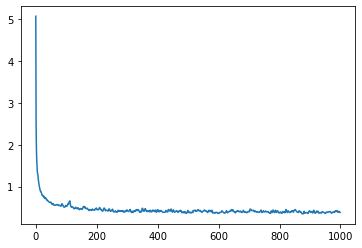

In [20]:
plt.plot(history.history['loss'])

In [21]:
if history.history['loss'][0] < history.history['loss'][-1]:
    breakme

### get z for training and test

In [22]:
z = encoder.predict(X_train)
z_test = encoder.predict(X_test)

### Test plot

In [23]:
Y_train

array([[6],
       [9],
       [9],
       ...,
       [6],
       [2],
       [8]], dtype=uint8)

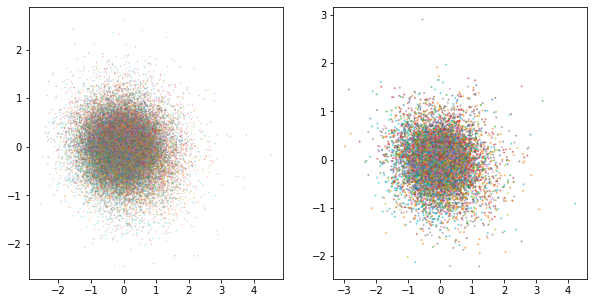

In [24]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=list(Y_train.flatten()), cmap=plt.cm.tab10)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=Y_test.flatten(), cmap=plt.cm.tab10)

### Save models + projections

In [25]:
import os

In [26]:
output_dir = MODEL_DIR/'projections'/ dataset / '64' / 'parametric-tsne'

In [27]:
encoder.save(os.path.join(output_dir, "encoder"))

W0720 11:56:10.979031 140341886531392 deprecation.py:506] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
I0720 11:56:11.307013 140341886531392 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cifar10/64/parametric-tsne/encoder/assets


In [28]:
np.save(output_dir / 'z.npy', z)
np.save(output_dir / 'z_test.npy', z_test)

### compute metrics

#### silhouette

In [29]:
from tfumap.silhouette import silhouette_score_block

In [30]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

-0.053554195512148885

In [31]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

-0.0562988394157417

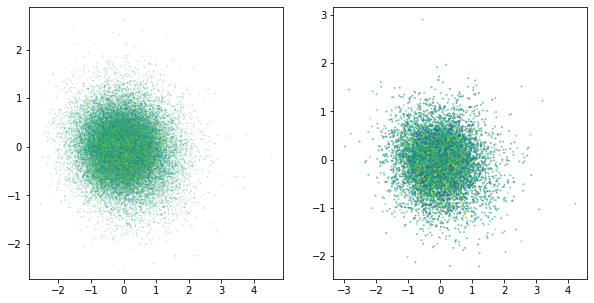

In [32]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.3556

In [35]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.3426

#### Trustworthiness

In [36]:
from sklearn.manifold import trustworthiness

In [37]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [38]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [39]:
tw, tw_test

(0.9971202081665332, 0.9973351901521217)

#### save output metrics

In [40]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, 'parametric-tsne', n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,cifar10,parametric-tsne,64,0.99712,-0.053554,"[0.010605490083386262, -0.09259850384062979, -..."


In [41]:
save_loc = DATA_DIR / 'projection_metrics' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

In [42]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, 'parametric-tsne', n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,cifar10,parametric-tsne,64,0.997335,-0.056299,"[-0.08281030682665703, 0.0796776595584265, 0.0..."


In [43]:
save_loc = DATA_DIR / 'projection_metrics' / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

In [44]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = ['parametric-tsne', n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,parametric-tsne,64,cifar10,0.3426,0.3556


In [45]:
save_loc = DATA_DIR / 'knn_classifier' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)